[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 142
    # data points      = 22
    # variables        = 4
    chi-square         = 6.4409e-09
    reduced chi-square = 3.5783e-10
    Akaike info crit   = -474.936228
    Bayesian info crit = -470.572058
[[Variables]]
    B0:   -13.3100024 +/- 0.32693612 (2.46%) (init = 0.022)
    E:     1.01381991 +/- 0.06438267 (6.35%) (init = 0.65)
    E_D:   3.32021372 +/- 0.27087379 (8.16%) (init = 4.4)
    T_pk:  319.121421 +/- 0.19079194 (0.06%) (init = 309)
[[Correlations]] (unreported correlations are < 0.100)
    C(B0, E)     = -0.998
    C(E, T_pk)   = -0.754
    C(B0, T_pk)  =  0.722
    C(E, E_D)    = -0.718
    C(B0, E_D)   =  0.682
    C(E_D, T_pk) =  0.626


SystemExit: 0

C:\Users\aleja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


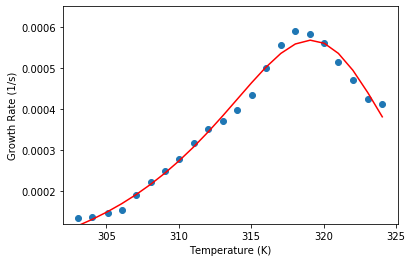

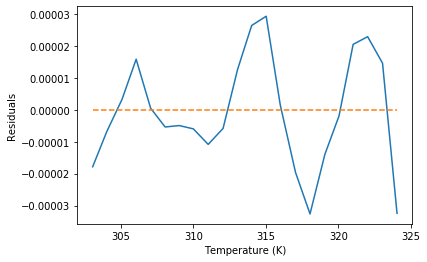

In [32]:
#!/usr/bin/env python3

__appname__ = '[App_name_here]'
__author__ = 'Pablo Lechon (plechon@ucm.es)'
__version__ = '0.0.1'

## IMPORTS ##

import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from lmfit import Minimizer, Parameters, fit_report, report_fit

## CONSTANTS ##

global R
global Tref
R = 8.62e-5 #Boltzmann constant
Tref = 273.15 #Reference temperature - 0C


## FUNCTIONS ##

class schoolfield():
    
    def set_parameters(self, params):
        
        #                Name, Start, Vary, Lower, Upper
        params.add_many(('B0',   0.022, True, -np.inf, np.inf ),
                        ('E',    0.65 , True, 10E-3,   np.inf ), 
                        ('E_D',  4.4,   True, 10E-10,  np.inf ),
                        ('T_pk', 309,   True, 273.15,  np.inf))
        #Eventually the initial values will come from a function that will 
        #belong to the schoolfield class
        return params


    def model(self, params, T, mu_max):
        "Model implementation"

        #Unpack values of parameters.
        parameter_vals = params.valuesdict()
        #Basic metabolic rate
        B0 = parameter_vals['B0'] 
        #Activation energy of enzymes
        E = parameter_vals['E'] 
        #Inactivation energy of enzymes
        E_D = parameter_vals['E_D']         
        #Temperature at which peak response is observed
        T_pk = parameter_vals['T_pk']
        #Calculate theoretical predictions
        result = (B0 + \
                np.log(np.exp((-E / R) * ((1 / T) - (1 / Tref))) /\
                (1 + (E/(E_D - E)) * np.exp(E_D / R * (1 / T_pk - (1 / T))))) )

        return np.exp(result) - mu_max

def main(argv):
    '''Main function'''

    #Read data
    db = pd.read_csv('Data/eme_db1.csv')
    data = db[db['ID'] == db.iloc[1, 1]]
    T = data.Temp + 273
    mu_max = data.TraitVal

    #Create model object from schoolfield class
    model = schoolfield()
    #Set parameters of the model
    params = Parameters()
    params = model.set_parameters(params)

    #Fit model
    minner = Minimizer(userfcn = model.model, params = params, 
                       fcn_args = (T, mu_max))
    result = minner.minimize(method = 'leastsq')

    print(fit_report(result))
    #Plot results 
    plt.figure(1)
    plt.scatter(T, mu_max)
    max_y = mu_max.max() * 1.1
    min_y = mu_max.min() * 0.9
    plt.ylim(min_y, max_y)
    plt.plot(T, model.model(result.params, T, mu_max) + mu_max, color = 'red')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Growth Rate (1/s)')
    plt.savefig('Results/first_fit.pdf')
    
    plt.figure(2)
    plt.plot(T, result.residual)
    zero = T * 0
    plt.plot(T, zero, '--')
    plt.ylabel('Residuals')
    plt.xlabel('Temperature (K)')

    return 0

## CODE ##

if (__name__ == '__main__'):
    status = main(sys.argv)
    sys.exit(status)

In [ ]:
## IMPROVING THE RESIDUAL CURVE ##
